In [ ]:
!pip install opencv-contrib-python

In [2]:
import cv2
import os
import sys
import numpy as np
import math 
import random
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Lambda
from keras.applications import VGG16


from google.colab import drive

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
os.listdir('/content/gdrive/My Drive/sample_faces')

['FB_IMG_1547999529671.jpg',
 'IMG_0897.JPG',
 'IMG_0904.JPG',
 'FOTO_01.jpg',
 'FOTO_02.jpg',
 'FOTO_03.jpg',
 'FOTO_04.jpg',
 'FB_IMG_1561892726387.jpg',
 'img2.jpg',
 'img1.jpg',
 'img3.jpg',
 'img4.jpg',
 'detected_faces']

In [5]:
filename = '/content/gdrive/My Drive/haarcascade_frontalface_default.xml'
face_cascades = cv2.CascadeClassifier(filename)  #pre-trained face detector 

In [6]:
def detect_faces(img, draw_box = True):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascades.detectMultiScale(grayscale_img, scaleFactor = 1.6)
    x,y,width,height = (0,0,0,0) #this goddamn thing doesn't work without a shitty redundant initialization!!!
    for (x, y, width, height) in faces:
        if draw_box:
            cv2.rectangle(img, (x ,y), (x+width, y+height), (0,0,255), 5) #image, start point, stop point, color, thickness
    face_box = img[y:y+height, x:x+width]
    face_coords = [x,y,width,height]
    return img, face_box, face_coords
        
    

In [7]:
path = '/content/gdrive/My Drive/sample_faces/'
files = os.listdir(path)
images = [file for file in files if 'jpg' in file]
fotos = [path+image for image in images]
fotos



['/content/gdrive/My Drive/sample_faces/FB_IMG_1547999529671.jpg',
 '/content/gdrive/My Drive/sample_faces/FOTO_01.jpg',
 '/content/gdrive/My Drive/sample_faces/FOTO_02.jpg',
 '/content/gdrive/My Drive/sample_faces/FOTO_03.jpg',
 '/content/gdrive/My Drive/sample_faces/FOTO_04.jpg',
 '/content/gdrive/My Drive/sample_faces/FB_IMG_1561892726387.jpg',
 '/content/gdrive/My Drive/sample_faces/img2.jpg',
 '/content/gdrive/My Drive/sample_faces/img1.jpg',
 '/content/gdrive/My Drive/sample_faces/img3.jpg',
 '/content/gdrive/My Drive/sample_faces/img4.jpg']

In [113]:
#sample of detected faces: (doesn't quite work for some faces might not be detected)
for image in images:
    img = cv2.imread(path+image)
    detected_faces, boxes, _ = detect_faces(img)
    cv2.imwrite(path+'detected_faces/'+image, detected_faces)


In [8]:
#function to return frontal face-shots:
def face(foto, name):
  pic = cv2.imread(foto)
  try:
    a,b,_ = detect_faces(pic)
    shot = cv2.imwrite(path+'detected_faces/'+name+'.jpg', b)
  except:
    shot = cv2.imwrite(path+'detected_faces/'+name+'.jpg', pic)

  return shot

In [182]:
face(fotos[5], 'cara5')

True

In [9]:
#frontal faces database:
faces_dir = '/content/gdrive/My Drive/att_faces/'


In [12]:
X_train, Y_train = [], []
X_test, Y_test = [], []

subfolders = sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])

In [13]:
for idx, folder in enumerate(subfolders):
    for file in sorted(os.listdir(folder)):
        img = keras.preprocessing.image.load_img(folder+'/'+file, color_mode = 'grayscale')
        img = keras.preprocessing.image.img_to_array(img).astype('float32')/255
        if idx < 35:
            X_train.append(img)
            Y_train.append(idx)
        else:
            X_test.append(img)
            Y_test.append(idx-35)

In [14]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
subject_idx = 5

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3 ,3, figsize = (10,10))
subject_img_idx = np.where(Y_train == subject_idx)[0]#.tolist()
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap ='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()


In [55]:

def create_shared_network(input_shape):
    model = Sequential()
    model.add(Conv2D(128, (3,3), activation = 'relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(128, activation = 'sigmoid'))
    return model

In [152]:
#using pre-trained model (only works for RGB images)
def deep_shared_network(input_shape):
  vgg16 = VGG16(include_top=False, weights = 'imagenet', input_shape = input_shape)

  for layer in vgg16.layers:
    layer.trainable = False

  input_ = vgg16.input
  output_ = vgg16(input_)
  last_layer = Flatten(name = 'flatten')(output_)
  last_layer = Dense(128, activation='sigmoid')(last_layer)

  model = Model(inputs = input_, outputs = last_layer)

  return model


In [56]:
input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)

In [57]:
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

In [58]:
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)

In [59]:
K = keras.backend

def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1-vector2), axis= 1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [60]:
distance = Lambda(euclidean_distance, output_shape =(1,))([output_top, output_bottom])

In [61]:
model = Model(inputs =[input_top, input_bottom], outputs = distance)

In [62]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          18744768    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[0][0]    

In [63]:
def create_pairs(X, Y, num_classes):
    pairs, labels = [], []
    class_idx = [np.where(Y == i)[0] for i in range(num_classes)]
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
    for c in range(num_classes):
        for n in range(min_images):
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1,img2))
            labels.append(1.0)
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0.0)
    return np.array(pairs), np.array(labels)
    

In [64]:
num_classes = len(np.unique(Y_train))
training_pairs, training_labels = create_pairs(X_train, Y_train, len(np.unique(Y_train)))
test_pairs, test_labels = create_pairs(X_test, Y_test, len(np.unique(Y_test)))

In [65]:
def contrastive_loss(Y_true, D):
    margin = 1
    return K.mean(Y_true*K.square(D)+(1 - Y_true)*K.maximum((margin-D),0))

In [66]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [67]:
model.compile(loss=contrastive_loss, optimizer ='adam', metrics=[accuracy])
callbacks = [keras.callbacks.EarlyStopping(patience=3, monitor = 'loss')]

In [68]:
model.fit([training_pairs[:,0], training_pairs[:,1]], training_labels, batch_size=64, epochs=20)#, callbacks=callbacks)

Epoch 1/20
10/10 [==============================] - 38s 4s/step - loss: 0.2371 - accuracy: 0.7686
Epoch 2/20
10/10 [==============================] - 38s 4s/step - loss: 0.1147 - accuracy: 0.9001
Epoch 3/20
10/10 [==============================] - 38s 4s/step - loss: 0.0714 - accuracy: 0.9638
Epoch 4/20
10/10 [==============================] - 39s 4s/step - loss: 0.0442 - accuracy: 0.9885
Epoch 5/20
10/10 [==============================] - 38s 4s/step - loss: 0.0334 - accuracy: 0.9969
Epoch 6/20
10/10 [==============================] - 39s 4s/step - loss: 0.0281 - accuracy: 0.9984
Epoch 7/20
10/10 [==============================] - 38s 4s/step - loss: 0.0241 - accuracy: 0.9984
Epoch 8/20
10/10 [==============================] - 38s 4s/step - loss: 0.0222 - accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 38s 4s/step - loss: 0.0189 - accuracy: 0.9984
Epoch 10/20
10/10 [==============================] - 38s 4s/step - loss: 0.0167 - accuracy: 1.0000
Epoch 11/20
10/10 [

In [69]:
model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)

3/3 [==============================] - 1s 293ms/step - loss: 0.1718 - accuracy: 0.9046


[0.17181742191314697, 0.9046474099159241]

In [70]:
#model.save('siamese_nn.h5')
carpeta = '/content/gdrive/My Drive/' #carpeta de fotos // this is always the root file when working in colab

In [176]:
#function to pre-process the input fotos.
def preprocess(x, name):
  face(carpeta+x, name) #obtained file with cropped face
  image = cv2.imread(path+'detected_faces/'+name+'.jpg',0)
  image = image.astype('float32')/255
  image = cv2.resize(image, (92, 112))
  image = image.reshape(1, image.shape[0], image.shape[1], 1)

  return image


In [80]:
#create random pair of face-shots:
face(fotos[random.randint(0,len(fotos))], 'true')
face(fotos[random.randint(0,len(fotos))], 'test')

True

In [81]:

foto1= 'true'
#foto1 = 'FOTO_03.jpg'
#foto1 = 'FOTO_01.jpg' 
true_img = cv2.imread(path+'detected_faces/'+foto1+'.jpg', 0)
true_img = true_img.astype('float32')/255
true_img = cv2.resize(true_img, (92, 112))
true_img = true_img.reshape(1, true_img.shape[0], true_img.shape[1], 1)

In [82]:

foto2 ='test'
#'FB_IMG_1547999529671.jpg'
#'FOTO_02.jpg'
#foto2 = 'FOTO_04.jpg'
#foto2 = 'Bewerbungsfoto.jpg' 
test_img = cv2.imread(path+'detected_faces/'+foto2+'.jpg', 0)
test_img = test_img.astype('float32')/255
test_img = cv2.resize(test_img, (92, 112))
test_img = test_img.reshape(1, test_img.shape[0], test_img.shape[1], 1)

In [83]:
resultados = model.predict([true_img, test_img])

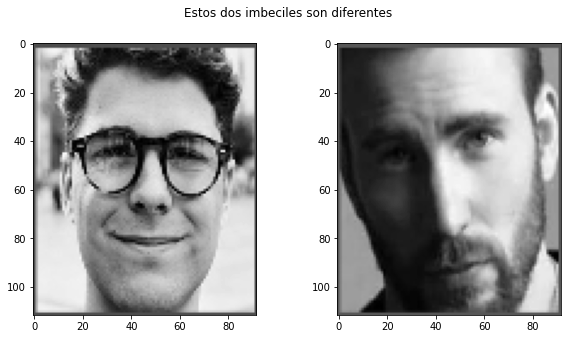

Disimilitud: 0.9296199679374695 


In [84]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(np.squeeze(true_img), cmap = 'gray')
ax2.imshow(np.squeeze(test_img), cmap = 'gray')
if 1-resultados[0][0] > 0.5:
    fig.suptitle('Estos dos papis son la misma persona!')
else:
    fig.suptitle('Estos dos imbeciles son diferentes')
plt.show()
print('Disimilitud: {} '.format(resultados[0][0]))